In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.linalg import solve
from scipy.interpolate import RectBivariateSpline

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_channel
from scripts.potentials import Potential
from scripts.tools import (
    build_coupled_channel_matrix, decompose_coupled_channel_matrix
)

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
class TMatrix(Potential):
    """Class that computes the half off-shell T-matrix."""
    
    def __init__(self, kvnn, channel, kmax, kmid, ntot):
        
        # Set channel argument to be compatible with potential functions
        self.tmatrix_channel = channel
        potential_channel = coupled_channel_shorthand(channel)
        
        # Initialize Potential class
        super().__init__(kvnn, potential_channel, kmax, kmid, ntot)
        
        # Get potential in units fm
        V_matrix = self.load_potential()

        # Load momenta and weights in fm^-1
        self.k_array, self.k_weights = self.load_mesh()
        
        # Maximum momentum value in fm^-1
        self.k_max = round(max(self.k_array))
        
        # Number of points in momentum mesh
        self.ntot = ntot
        
        # Interpolate potential
        if self.coupled_channel_bool:
            
            # Get V sub-blocks
            V11, V12, V21, V22 = decompose_coupled_channel_matrix(V_matrix)
        
            # Interpolate each sub-block separately
            self.V11_func = RectBivariateSpline(self.k_array, self.k_array, V11)
            self.V12_func = RectBivariateSpline(self.k_array, self.k_array, V12)
            self.V21_func = RectBivariateSpline(self.k_array, self.k_array, V21)
            self.V22_func = RectBivariateSpline(self.k_array, self.k_array, V22)
            
        else:
            
            self.V_func = RectBivariateSpline(self.k_array, self.k_array,
                                              V_matrix)

    def evaluate(self, pp):
        """Compute the T-matrix in units [fm] where we use the mesh k_i and
        p' with E' = p'^2 / M.
        """
        
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0/np.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - pp ** 2))
        # ntot+1 element of D_vector [fm^-1]
#         D_last = (
#             -2.0/np.pi * pp ** 2
#             * (np.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
#                + np.log((self.k_max + pp) / (self.k_max - pp)) / (2.0 * pp))
#         ) + 1j * pp
        ### TESTING
        D_last = (
            -2.0/np.pi * pp ** 2
            * (np.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
               + np.log((self.k_max + pp) / (self.k_max - pp)) / (2.0 * pp))
        ) - 1j * pp
        # Append ntot+1 element to D_vector
        D_vector = np.append(D_vector, D_last)  # Length is now ntot+1
        
        # p' can be appended to end of k_array regardless of its value
        k_full = np.append(self.k_array, pp)
        
        # Create meshes for interpolation
        k_grid, kp_grid = np.meshgrid(k_full, k_full, indexing='ij')
        
        if self.coupled_channel_bool:
            
            # Append p' points by using the interpolated potential
            V11_matrix = self.V11_func.ev(k_grid, kp_grid)
            V12_matrix = self.V12_func.ev(k_grid, kp_grid)
            V21_matrix = self.V21_func.ev(k_grid, kp_grid)
            V22_matrix = self.V22_func.ev(k_grid, kp_grid)
            
            # Build coupled-channel matrix
            V_matrix = build_coupled_channel_matrix(V11_matrix, V12_matrix,
                                                    V21_matrix, V22_matrix)

            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(2 * (self.ntot + 1))
                + np.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_matrix
            )
            
        else:
            
            # Append p' points by using the interpolated potential
            V_matrix = self.V_func.ev(k_grid, kp_grid)
            
            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(self.ntot + 1)
                + np.tile(D_vector, (self.ntot + 1, 1)) * V_matrix
            )

        # Calculate T-matrix in fm
        T_matrix = solve(F_matrix, V_matrix)

        # Shape is (ntot+1, ntot+1) or (2*ntot+2, 2*ntot+2)
        return T_matrix
    
    def half_offshell(self, T_matrix):
        """Returns the half off-shell T-matrix T_{L, L'}(k_i, p') given a
        sub-block of the coupled-channel. Works for non-coupled-channels too.
        """
        
        if self.tmatrix_channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            
            k_i_start, k_i_end = 0, self.ntot
            pp_index = 2 * self.ntot + 1
            
        elif self.tmatrix_channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            
            k_i_start, k_i_end = self.ntot + 1, 2 * self.ntot + 1
            pp_index = self.ntot
            
        elif self.tmatrix_channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            
            k_i_start, k_i_end = self.ntot + 1, 2 * self.ntot + 1
            pp_index = 2 * self.ntot + 1
        
        else:
            
            k_i_start, k_i_end = 0, self.ntot
            pp_index = self.ntot
            
        # Array with shape (ntot, 1)
        return T_matrix[k_i_start:k_i_end, pp_index]
    
    def onshell(self, T_matrix):
        """Returns the on-shell T-matrix T_{L, L'}(p', p') given a sub-block of
        the coupled-channel. Works for non-coupled-channels too.
        """
        
        if self.tmatrix_channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            
            ipp_index = self.ntot
            jpp_index = 2 * self.ntot + 1
            
        elif self.tmatrix_channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            
            ipp_index = 2 * self.ntot + 1
            jpp_index = self.ntot
            
        elif self.tmatrix_channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            
            ipp_index = 2 * self.ntot + 1
            jpp_index = 2 * self.ntot + 1
        
        else:
            
            ipp_index = self.ntot
            jpp_index = self.ntot
            
        # Scalar
        return T_matrix[ipp_index, jpp_index]
        
    def test_phase_shifts(self, k0):
        """Get phase shift from the T-matrix with scattering energy
            E = (\hbar*k0)^2 / M.
        Note, this won't work for coupled-channels yet.
        """

        # Build D_vector
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0/np.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - k0 ** 2))
        # ntot+1 element of D_vector [fm^-1]
        D_last = (
            -2.0/np.pi * k0 ** 2
            * (np.sum(self.k_weights / (self.k_array ** 2 - k0 ** 2))
               + np.log((self.k_max + k0) / (self.k_max - k0)) / (2.0 * k0))
        ) + 1j * k0
        ### TESTING
#         D_last = (
#             -2.0/np.pi * k0 ** 2
#             * (np.sum(self.k_weights / (self.k_array ** 2 - k0 ** 2))
#                + np.log((self.k_max + k0) / (self.k_max - k0)) / (2.0 * k0))
#         ) - 1j * k0
        # Append ntot+1 element to D_vector
        D_vector = np.append(D_vector, D_last)  # Length is now ntot+1
        
        # k0 can be appended to end of k_array regardless of its value
        k_full = np.append(self.k_array, k0)
        
        # Create meshes for interpolation
        k_grid, kp_grid = np.meshgrid(k_full, k_full, indexing='ij')
        
        # Append k0 points by using the interpolated potential
        V_matrix = self.V_func.ev(k_grid, kp_grid)
            
        # Build F matrix where F_ij = delta_ij + D_j V_ij
        F_matrix = (
            np.identity(self.ntot + 1)
            + np.tile(D_vector, (self.ntot + 1, 1)) * V_matrix
        )
            
        # Calculate T-matrix in fm
        T_matrix = solve(F_matrix, V_matrix)
        
        # Phase shift \delta in degrees
        delta = np.angle(-k0 * T_matrix[-1, -1], deg=True)
        
        return delta

In [5]:
def coupled_channel_shorthand(channel_full):
    """Convert partial wave channel string (e.g., 3D1-3S1) to shorthand
    notation (e.g., 3S1).
    """
    
    if channel_full[:3] == '3D1':
        channel_short = '3S1'
    elif channel_full[:3] == '3F2':
        channel_short = '3P2'
    elif channel_full[:3] == '3G3':
        channel_short == '3D3'
    else:
        channel_short = channel_full[:3]
        
    return channel_short

In [6]:
def compute_phase_shifts(e_array, kvnn, channel, kmax=30.0, kmid=4.0, ntot=120):
    """Check phase shifts of T-matrix."""
    
    delta_array = np.zeros_like(e_array)
    
    tmatrix = TMatrix(kvnn, channel, kmax, kmid, ntot)
    
    for i, ie in enumerate(e_array):
        
        # Convert energy E_lab [MeV] to relative momentum [fm^-1]
        k0 = np.sqrt(ie / 2.0 / Potential.hbar_sq_over_m)
        
        delta_array[i] = tmatrix.test_phase_shifts(k0)

    return delta_array

In [7]:
def compare_phase_shifts(channel, x_limits=(0,100), y_limits=None):
    """Compare phase shifts to PWA93 data from NN-online."""
    
    # Get PWA93 data
    filename = f"pwa93_{channel}np.txt"
    data = np.loadtxt("../data/phase_shifts/" + filename)
    elab_pwa93_array = data[:, 0]
    delta_pwa93_array = data[:, 1]
    
    # Compare to T-matrix phase shifts from AV18
    kvnn = 6
    elab_av18_array = np.linspace(0.001, 100.0, 100)
    delta_av18_array = compute_phase_shifts(elab_av18_array, kvnn, channel)
    
    # Compare phase shifts
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(elab_av18_array, delta_av18_array, label='AV18')
    ax.plot(elab_pwa93_array, delta_pwa93_array, label='PWA93', ls='dashdot')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12)
    ax.set_xlabel(r"E$_{\rm{lab}}$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$\delta$ [deg]", fontsize=16)
    title = label_channel(channel, label_coupled_channel=False)
    ax.set_title(title, fontsize=16);

In [8]:
def get_S_matrix_from_phase_shifts(elab_array, delta_array):
    """Compute the S-matrix using S(E) = exp(2i * \delta(E))."""
    
    # Convert phase shifts to radians
    delta_radians_array = np.radians(delta_array)
    
    return np.exp(2j * delta_radians_array)

In [9]:
def get_S_matrix_from_tmatrix(elab, T_onshell):
    """Compute the S-matrix using S_l(E) = 1 + 2i * k * T_l(k,k;E)."""
    
    # Convert energy E_lab [MeV] to relative momentum [fm^-1]
    k0 = np.sqrt(elab / 2.0 / Potential.hbar_sq_over_m)

#     return 1 + 2j * k0 * T_onshell
    ### TESTING
    return 1 - 2j * k0 * T_onshell

In [10]:
def check_S_matrix(channel, x_limits=None, y_limits=(0.99,1.01)):
    """Check that |S_l(E)| = 1."""
    
    # Lab energy [MeV]
    elab_array = np.linspace(0.001, 20.0, 100)
    
    # Do AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    # Get S-matrix from scattering phase shifts
    delta_deg_array = compute_phase_shifts(elab_array, kvnn, channel)
    S_phase_array = get_S_matrix_from_phase_shifts(elab_array, delta_deg_array)
    
    # Get S-matrix from T-matrix
    tmatrix = TMatrix(kvnn, channel, kmax, kmid, ntot)
    S_tmatrix_array = np.zeros_like(elab_array, dtype=complex)
    for i, ie in enumerate(elab_array):
        # Convert energy E_lab [MeV] to relative momentum [fm^-1]
        k0 = np.sqrt(ie / 2.0 / Potential.hbar_sq_over_m)
        T_matrix = tmatrix.evaluate(k0)
        T_onshell = tmatrix.onshell(T_matrix)
        S_tmatrix_array[i] = get_S_matrix_from_tmatrix(ie, T_onshell)
        
    # Plot |S_l(E)| as a function of energy
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(elab_array, np.abs(S_phase_array), label=r"$e^{2i \delta}$")
    ax.plot(elab_array, np.abs(S_tmatrix_array), label=r"$1-2i k T_l$",
            ls='dashdot')
    ax.axhline(y=1.0, color='black', ls='dotted')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12)
    ax.set_xlabel(r"E$_{\rm{lab}}$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$|S(E)|$", fontsize=16)
    title = label_channel(channel, label_coupled_channel=False)
    ax.set_title(title, fontsize=16);

In [11]:
def check_unitarity(channel, x_limits=None, y_limits=None):
    """Check the condition that T_l(E) - T_l(E)^* = 2i k |T_l(E)|^2."""
    
    # Lab energy [MeV]
    elab_array = np.linspace(0.001, 20.0, 100)
    
    # Do AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    # Evaluate on-shell T-matrix
    tmatrix = TMatrix(kvnn, channel, kmax, kmid, ntot)
    imag_array = np.zeros_like(elab_array)
    abs_array = np.zeros_like(elab_array)
    for i, ie in enumerate(elab_array):
        
        # Convert energy E_lab [MeV] to relative momentum [fm^-1]
        k0 = np.sqrt(ie / 2.0 / Potential.hbar_sq_over_m)
        T_matrix = tmatrix.evaluate(k0)
        T_onshell = tmatrix.onshell(T_matrix)
        
        imag_array[i] = np.imag(T_onshell)
        abs_array[i] = k0 * np.abs(T_onshell) ** 2
        
    # Print values
    header = f"E [MeV] \t Im[T(E)] [fm] \t k |T(E)|^2 [fm]\n"
    print(header)
    for ie, iimag, iabs in zip(elab_array, imag_array, abs_array):
        
        line = f"{ie:^10.2f}{iimag:^25.3e}{iabs:^25.3e}"
        print(line)

In [12]:
def check_symmetry(k0):
    """Check that T_{LL'}(k,k') = T_{L'L}(k',k) in 3S1-3D1 coupled-channel."""
    
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    tmatrix_3S1_3D1 = TMatrix(kvnn, '3S1-3D1', kmax, kmid, ntot)
    tmatrix_3D1_3S1 = TMatrix(kvnn, '3D1-3S1', kmax, kmid, ntot)
    
    T_02_matrix = tmatrix_3S1_3D1.evaluate(k0)
    T_20_matrix = tmatrix_3D1_3S1.evaluate(k0)
    
    diff_matrix = T_02_matrix - T_20_matrix.T
    
    print(diff_matrix)

## Checking phase shifts

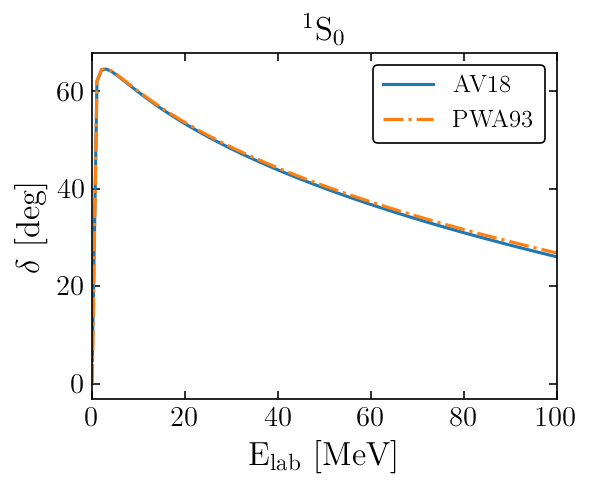

In [13]:
# 1S0 phase shifts with T-matrix
compare_phase_shifts('1S0')

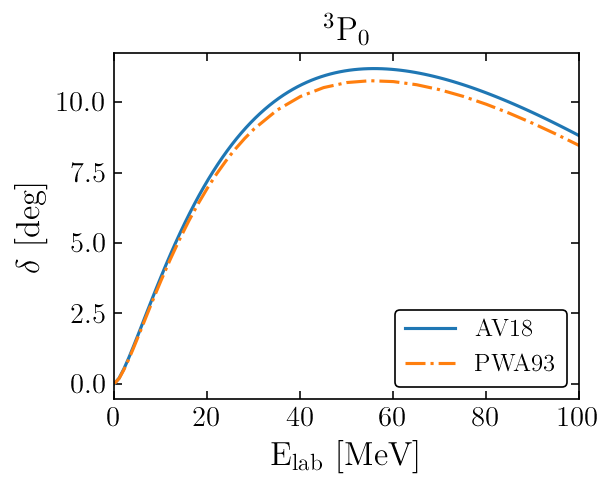

In [14]:
# 3P0 phase shifts with T-matrix
compare_phase_shifts('3P0')

## $S-$matrix $S_l = 1 - 2 i k T_l$

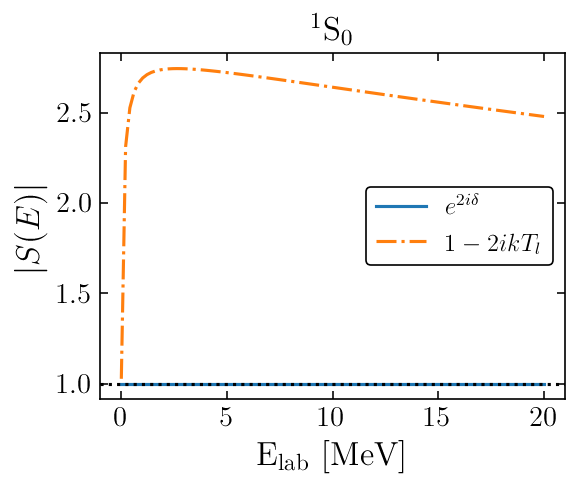

In [15]:
# ylim = (0.99, 1.01)
ylim = None
check_S_matrix('1S0', y_limits=ylim)

## $\text{Im}[T(k_0, k_0; E_0)] = k_0 \lvert T(k_0, k_0; E_0) \rvert^2$

In [16]:
check_unitarity('1S0')

E [MeV] 	 Im[T(E)] [fm] 	 k |T(E)|^2 [fm]

   0.00           1.941e+00                1.941e+00        
   0.20           1.096e+01                1.096e+01        
   0.41           9.630e+00                9.630e+00        
   0.61           8.537e+00                8.537e+00        
   0.81           7.712e+00                7.712e+00        
   1.01           7.071e+00                7.071e+00        
   1.21           6.558e+00                6.558e+00        
   1.42           6.135e+00                6.135e+00        
   1.62           5.780e+00                5.780e+00        
   1.82           5.475e+00                5.475e+00        
   2.02           5.210e+00                5.210e+00        
   2.22           4.978e+00                4.978e+00        
   2.43           4.771e+00                4.771e+00        
   2.63           4.585e+00                4.585e+00        
   2.83           4.418e+00                4.418e+00        
   3.03           4.265e+00               

## $T_{L,L'}(k, k'; E_0) = T_{L',L}(k', k; E_0)$

In [17]:
k0 = 0.5
check_symmetry(k0)

[[ 0.00000000e+00+0.00000000e+00j -2.22044605e-16+2.22044605e-15j
   6.66133815e-16-8.88178420e-16j ... -2.61101215e-19-7.86046575e-19j
  -3.03237795e-19-1.08420217e-19j  2.22044605e-16-7.14706072e-16j]
 [ 2.22044605e-16-2.22044605e-15j  0.00000000e+00+0.00000000e+00j
   4.44089210e-16+4.44089210e-16j ...  9.90929287e-19-6.77626358e-19j
  -1.82959117e-19-8.13151629e-20j  5.82867088e-16-6.66133815e-16j]
 [-6.66133815e-16+8.88178420e-16j -4.44089210e-16-4.44089210e-16j
   0.00000000e+00+0.00000000e+00j ...  2.86211109e-19-9.75781955e-19j
   3.21025487e-19-1.35525272e-19j  7.49400542e-16-6.52256027e-16j]
 ...
 [ 2.61101215e-19+7.86046575e-19j -9.90929287e-19+6.77626358e-19j
  -2.86211109e-19+9.75781955e-19j ...  0.00000000e+00+0.00000000e+00j
   1.73472348e-18+5.12851980e-23j -9.82558219e-20-2.96461532e-20j]
 [ 3.03237795e-19+1.08420217e-19j  1.82959117e-19+8.13151629e-20j
  -3.21025487e-19+1.35525272e-19j ... -1.73472348e-18-5.12851980e-23j
   0.00000000e+00+0.00000000e+00j -1.01643954e-

In [18]:
k0 = 1.5
check_symmetry(k0)

[[ 0.00000000e+00+0.00000000e+00j -2.22044605e-15-8.88178420e-16j
   1.77635684e-15+8.88178420e-16j ... -2.47841840e-18+2.43945489e-19j
  -2.46063071e-19-4.06575815e-19j -2.22044605e-15-5.55111512e-17j]
 [ 2.22044605e-15+8.88178420e-16j  0.00000000e+00+0.00000000e+00j
  -1.33226763e-15+3.33066907e-15j ... -2.15993402e-18+5.48877350e-19j
  -4.06575815e-19-3.59141970e-19j -2.77555756e-15-1.94289029e-16j]
 [-1.77635684e-15-8.88178420e-16j  1.33226763e-15-3.33066907e-15j
   0.00000000e+00+0.00000000e+00j ... -1.97019864e-18+3.93023288e-19j
  -4.54009660e-19-3.38813179e-19j -2.33146835e-15-1.38777878e-16j]
 ...
 [ 2.47841840e-18-2.43945489e-19j  2.15993402e-18-5.48877350e-19j
   1.97019864e-18-3.93023288e-19j ...  0.00000000e+00+0.00000000e+00j
   1.73472348e-18-7.77549776e-23j  6.77626358e-21+1.52465931e-20j]
 [ 2.46063071e-19+4.06575815e-19j  4.06575815e-19+3.59141970e-19j
   4.54009660e-19+3.38813179e-19j ... -1.73472348e-18+7.77549776e-23j
   0.00000000e+00+0.00000000e+00j -9.14795583e-